In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import re
import contractions
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge as R
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score as acu

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Bidirectional, Dense
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.math import rint, reduce_sum, divide, exp, subtract, greater_equal
from tensorflow.math import round as rounding
from tensorflow.random import set_seed
from tensorflow import cast, constant
from tensorflow.nn import softmax

from plot_keras_history import plot_history

from transformers import BertTokenizer, TFBertForSequenceClassification

import gensim
import gensim.downloader as api

seed = 111
np.random.seed(seed)
set_seed(seed)

In [2]:
# Get Data
train, test = pd.read_csv("input/train.csv"), pd.read_csv("input/test.csv")
y=train.target.values

In [3]:
display(train.head(2))
display(test.head(2))
display(y)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


array([1, 1, 1, ..., 1, 1, 1])

In [4]:
# 이모지 리스트
emojis = ["\U0001F600", "\U0001F64F", "\U0001F300", "\U0001F5FF", "\U0001F680", "\U0001F6FF", "\U0001F1E0", "\U0001F1FF", "\U00002702", "\U000027B0", "\U000024C2", "\U0001F251"]
emojis

['😀', '🙏', '🌀', '🗿', '🚀', '\U0001f6ff', '\U0001f1e0', '🇿', '✂', '➰', 'Ⓜ', '🉑']

In [5]:
# 스탑워즈 리스트
stopWords = nltk.corpus.stopwords.words("english")

In [6]:
# 단어 토크나이저
token = nltk.tokenize.RegexpTokenizer(r"\w+")

In [7]:
# 표제어 추출 기능
lemmatizer = nltk.stem.WordNetLemmatizer()

In [8]:
def cleaner(DF, labeled=True, stopWrds=True, Lemmatize=True, dropDigits=True, dropSinLet=True, c="text"):
    fake = []
    real = []
    data = []
    col = np.where(DF.columns == c)[0][0]
    for i, row in enumerate(DF.iterrows()):
        sentence = row[1][col]
        sentence = sentence.lower().split(" ")
        # remove emojis
        sentence = [word for word in sentence if word not in emojis]
        # remove http https @
        sentence = [word for word in sentence if "http" not in word and "https" not in word and "@" not in word]
        # you're -> you are, i'm -> I am
        sentence = [contractions.fix(word) for word in sentence]
        # merge string
        sentence = " ".join(sentence).lower()
        sentence = token.tokenize(sentence)
        if stopWrds == True:
            sentence = [word for word in sentence if word not in stopWords]
        if Lemmatize == True:
            sentence = [lemmatizer.lemmatize(word) for word in sentence]
        sentence = [word.strip() for word in sentence]
        if dropDigits == True:
            sentence = [word for word in sentence if not re.match(r"\S*\d+\S*", word)]
        sentence = [word for word in sentence if word != "rt" and word != "û_" and word != "amp" and word != "ûª" and word != "ûªs" and word != "ûò" and word != "åè" and word != "ìñ1"]
        sentence = [re.sub(r"(.)\1{2,}\B", r"\1\1", word) for word in sentence]
        sentence = [re.sub(r"(.)\1{2,}\b", r"\1\1", word) for word in sentence]
        if dropSinLet == True:
            sentence = [word for word in sentence if len(word) > 1]
        sentence = [word for word in sentence if len(word) < 30]
        if labeled == True:
            if row[1][4] == 1:
                fake.extend(sentence)
            else:
                real.extend(sentence)
        data.append(" ".join(sentence))
    return data, fake, real

In [9]:
tr, F, T = cleaner(train)
te, e, e = cleaner(test, labeled=False)

In [10]:
# EDA for frequency words
np.random.seed(seed)
r = np.random.uniform(low=0.0, high=1.0, size=train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2])
te_val, _, _ = cleaner(train.loc[r <= 0.2], labeled=False)

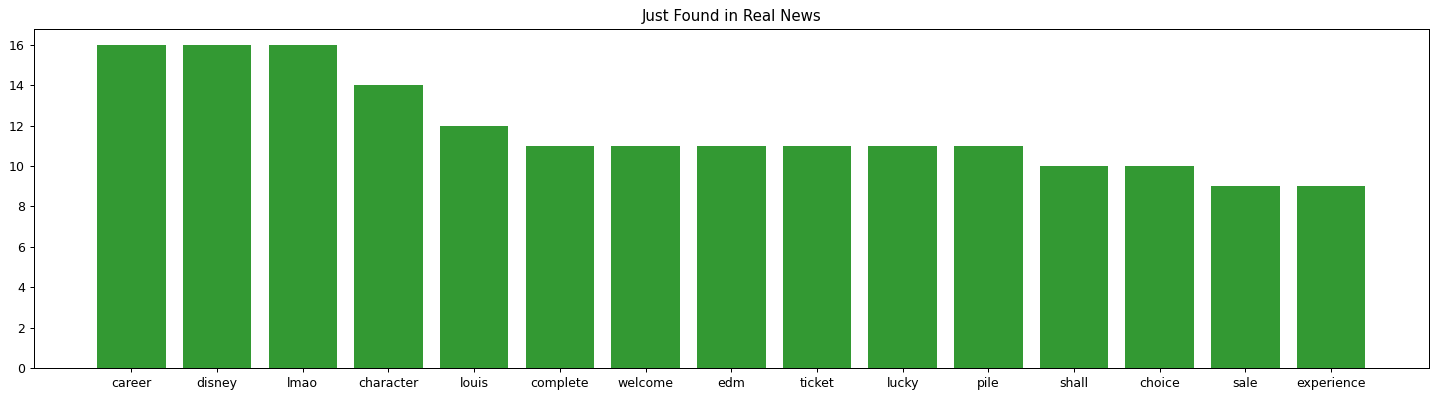

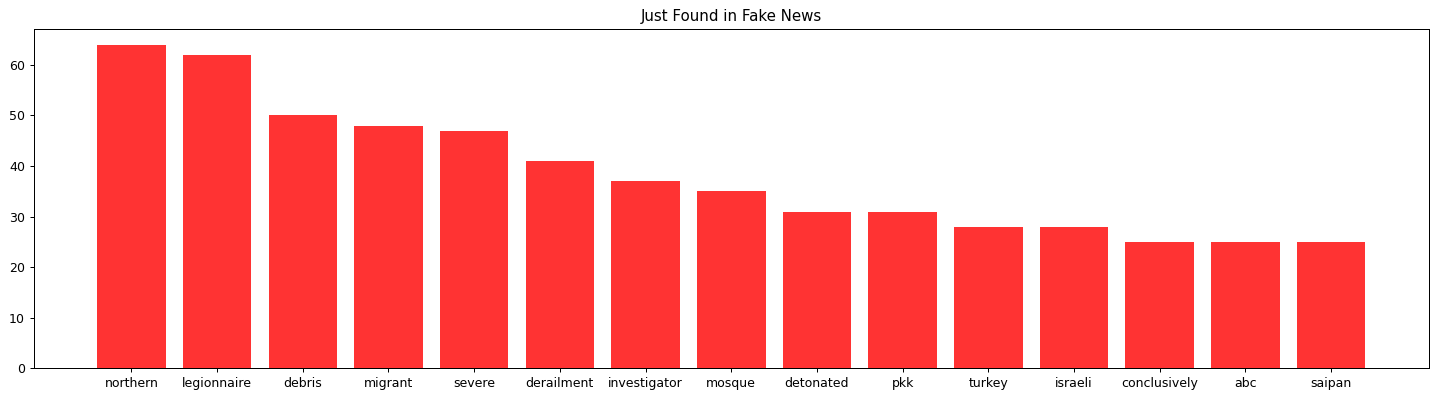

In [12]:
just_real = [w for w in T if w not in F]
just_fake = [w for w in F if w not in T]
Just_Real = nltk.probability.FreqDist()
Just_Fake = nltk.probability.FreqDist()
for w in just_real:
    Just_Real[w] += 1
for w in just_fake:
    Just_Fake[w] += 1
for C, W in {"green": Just_Real, "red": Just_Fake}.items():
    Frequency = pd.DataFrame({"Words": list(W.keys()),"Frequency": list(W.values())})
    Frequency = Frequency.sort_values("Frequency", ascending=False).iloc[:15]
    plt.figure(figsize=(20, 5), dpi=90)
    if C == "green":
        plt.title("Just Found in Real News")
    else:
        plt.title("Just Found in Fake News")
    plt.bar(Frequency.Words, Frequency.Frequency, color=C, alpha=0.8)

In [13]:
# N-Grams model
np.random.seed(seed)
r = np.random.uniform(low=0.0, high=1.0, size=train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2])
te_val, _, _ = cleaner(train.loc[r <= 0.2], labeled=False)

before = [i for i in tr_val if tr_val.index(i) in [0, 2]]

In [18]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.2, analyzer='char_wb', ngram_range=(3,7))
vectorizer.fit(tr_val + te_val)
tr = vectorizer.transform(tr_val)
te = vectorizer.transform(te_val)

In [19]:
model = R(alpha=0.2)

In [20]:
model.fit(tr, y_tr_val)

Ridge(alpha=0.2)

In [21]:
Predictions = model.predict(te)
Predictions = np.where(Predictions >= 0.8, 1, 0)

In [23]:
print("Accuracy using N-Grams is:", np.round(acu(Predictions, y_te_val)*100, 2), "%")

Accuracy using N-Grams is: 74.31 %


In [25]:
# LSTM
np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

before = [i for i in tr_val if tr_val.index(i) in [0,2]]

In [26]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr_val)
tr_val = tokenizer.texts_to_sequences(tr_val)
te_val = tokenizer.texts_to_sequences(te_val)

vocabulary_size_val = len(tokenizer.index_word)+1

after = [i for i in tr_val if tr_val.index(i) in [0,2]]

print("Before: \n" + str(before) + "\n\n" + "After: \n" + str(after))

Before: 
['our deeds are the reason of this earthquake may allah forgive us all', 'people receive wildfires evacuation orders in california']

After: 
[[106, 3646, 17, 1, 698, 6, 21, 339, 131, 1553, 5393, 72, 40], [56, 3647, 1403, 205, 1293, 4, 85]]


In [27]:
length_val=max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

In [28]:
tr_val = pad_sequences(tr_val, padding='post', maxlen=length_val)
te_val = pad_sequences(te_val, padding='post', maxlen=length_val)

print("After Padding to a length of: " + str(length_val) + "\n\n" + str(tr_val[[0,2]]))

After Padding to a length of: 31

[[ 106 3646   17    1  698    6   21  339  131 1553 5393   72   40    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [  56 3647 1403  205 1293    4   85    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]


In [29]:
def BiDirLSTM(vocSize, inpShape, seeds = seed):
    np.random.seed(seeds)
    set_seed(seeds)
    inp = Input(shape=(inpShape), name="input")
    emb = Embedding(input_dim=vocSize, output_dim=4)(inp)
    drop = Dropout(0.3)(emb)
    biLstm = Bidirectional(LSTM(units=16, activation='tanh', return_sequences=True, stateful=False, recurrent_dropout=0.4, dropout=0.4))(drop)
    biLstm = Bidirectional(LSTM(units=8, activation='tanh', return_sequences=False, stateful=False, recurrent_dropout=0.3, dropout=0.3))(biLstm)
    out = Dense(units=1, activation="sigmoid")(biLstm)
    m = Model(inputs=inp, outputs=out)
    m.summary()
    return m

In [30]:
model = BiDirLSTM(vocabulary_size_val, length_val)

2022-03-23 10:45:23.453914: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 31)]              0         
                                                                 
 embedding (Embedding)       (None, 31, 4)             48976     
                                                                 
 dropout (Dropout)           (None, 31, 4)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 31, 32)           2688      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 17    

In [32]:
optimizer = Adamax(learning_rate=0.01, decay=0.0005, clipvalue=10)

In [33]:
loss = BinaryCrossentropy(label_smoothing=0.01)

In [34]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [35]:
history = model.fit(x=tr_val, y=y_tr_val, validation_data=(te_val, y_te_val), epochs=10, batch_size=96, shuffle=True, verbose=1)

Epoch 1/10
64/64 [==============================] - 10s 67ms/step - loss: 0.6536 - accuracy: 0.6053 - val_loss: 0.5866 - val_accuracy: 0.7220
Epoch 2/10
64/64 [==============================] - 4s 57ms/step - loss: 0.5230 - accuracy: 0.7500 - val_loss: 0.4932 - val_accuracy: 0.7740
Epoch 3/10
64/64 [==============================] - 4s 57ms/step - loss: 0.4582 - accuracy: 0.7977 - val_loss: 0.4841 - val_accuracy: 0.7701
Epoch 4/10
64/64 [==============================] - 4s 58ms/step - loss: 0.4258 - accuracy: 0.8179 - val_loss: 0.4699 - val_accuracy: 0.7931
Epoch 5/10
64/64 [==============================] - 4s 57ms/step - loss: 0.3933 - accuracy: 0.8361 - val_loss: 0.4934 - val_accuracy: 0.7971
Epoch 6/10
64/64 [==============================] - 4s 58ms/step - loss: 0.3680 - accuracy: 0.8469 - val_loss: 0.4706 - val_accuracy: 0.7931
Epoch 7/10
64/64 [==============================] - 4s 57ms/step - loss: 0.3464 - accuracy: 0.8597 - val_loss: 0.5048 - val_accuracy: 0.8011
Epoch 8/10
6

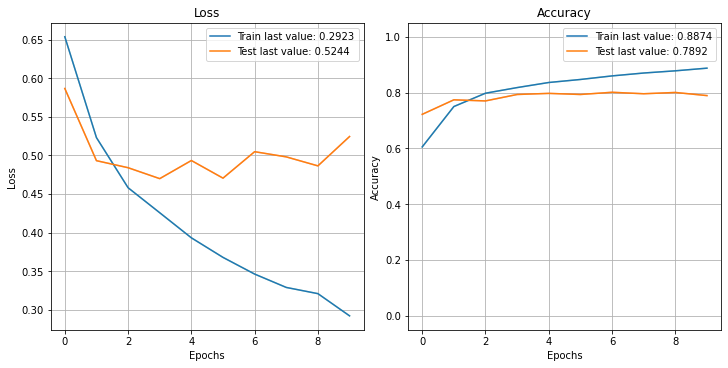

In [36]:
plot_history(history)
plt.show()

In [37]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, _, _ = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

In [38]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr)
tr = tokenizer.texts_to_sequences(tr)
te = tokenizer.texts_to_sequences(te)

vocabulary_size = len(tokenizer.index_word)+1

In [39]:
length = max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [40]:
tr = pad_sequences(tr, padding='post', maxlen=length)
te = pad_sequences(te, padding='post', maxlen=length)

In [41]:
model = BiDirLSTM(vocabulary_size, length)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 32, 4)             55600     
                                                                 
 dropout_1 (Dropout)         (None, 32, 4)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 32)           2688      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 17  

In [42]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [43]:
history = model.fit(x=tr, y=y, epochs=10, batch_size=96, shuffle=True, verbose=0)

In [44]:
Predictions = model.predict(x=te)

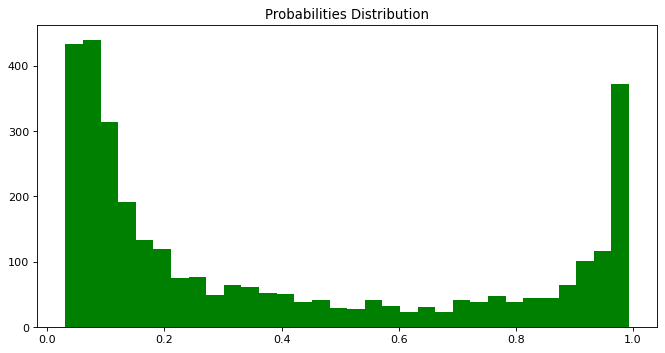

In [45]:
baseline = Predictions
plt.figure(figsize = (10,5), dpi = 80)
plt.hist(baseline, bins=32, color='g', label='baseline')
plt.title('Probabilities Distribution')
plt.show()

In [47]:
subm = pd.read_csv("input/sample_submission.csv")

In [48]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0


In [49]:
subm.to_csv("Submission_Basic.csv", index=False)

In [51]:
# word2vec with gensim
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, o, o = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

In [52]:
emb = [s.split(" ") for s in tr]
emb.extend([s.split(" ") for s in te])

In [53]:
w2v = gensim.models.Word2Vec(emb, min_count=4, workers=4, window=5, sg=1)
words=["fire", "flood", "died", "accident", "closed", "help", "twitter", "air", "everything"]
for w in words:
    print(w + " is " + w2v.wv.most_similar(w, topn=1)[0][0])

fire is buildings
flood is combo
died is bringing
accident is airplane
closed is multiple
help is control
twitter is weird
air is helicopter
everything is okay


In [54]:
def wordChanger(trainList, testList, minSimilar=0.5, numPrint=300):
    te_listList = [s.split(" ") for s in testList]
    tr_uniques=set(" ".join(trainList).split(" "))
    wc = 0
    try:
        for i, s in enumerate(te_listList):
            for j, w in enumerate(s):
                if w not in tr_uniques and w in w2v.wv.index_to_key and w2v.wv.most_similar(w, topn=1)[0][0] in tr_uniques \
                and w2v.wv.most_similar(w, topn=1)[0][1] >= minSimilar:
                    te_listList[i][j] = w2v.wv.most_similar(w, topn=1)[0][0]
                    wc += 1
                    if i < numPrint:
                        print(w + " changed in " + w2v.wv.most_similar(w, topn = 1)[0][0])
    except Error as e:
        print(w + " Err: " + e)
    print(str(wc) + " words changed")
    te_listList = [" ".join(s) for s in te_listList]
    return te_listList

In [55]:
te_val = wordChanger(tr_val, te_val)

kiss changed in cast
coahuila changed in tennessee
coahuila changed in tennessee
esp changed in bath
salvation changed in cyclist
salvation changed in cyclist
preseason changed in ems
esp changed in bath
keeping changed in struggle
higher changed in exploit
higher changed in exploit
48 words changed


In [56]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr_val)
tr_val = tokenizer.texts_to_sequences(tr_val)
te_val = tokenizer.texts_to_sequences(te_val)

vocabulary_size_val = len(tokenizer.index_word) + 1

In [57]:
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

In [58]:
tr_val = pad_sequences(tr_val, padding='post', maxlen=length_val)
te_val = pad_sequences(te_val, padding='post', maxlen=length_val)

In [59]:
model = BiDirLSTM(vocabulary_size_val, length_val)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 31)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 31, 4)             48976     
                                                                 
 dropout_2 (Dropout)         (None, 31, 4)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 31, 32)           2688      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 17  

In [60]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [61]:
history = model.fit(x=tr_val, y=y_tr_val, validation_data=(te_val, y_te_val), epochs=10, batch_size=96, shuffle=True, verbose=1)

Epoch 1/10
64/64 [==============================] - 10s 68ms/step - loss: 0.6826 - accuracy: 0.5696 - val_loss: 0.6769 - val_accuracy: 0.5586
Epoch 2/10
64/64 [==============================] - 4s 58ms/step - loss: 0.6033 - accuracy: 0.6750 - val_loss: 0.5449 - val_accuracy: 0.7424
Epoch 3/10
64/64 [==============================] - 4s 58ms/step - loss: 0.5170 - accuracy: 0.7575 - val_loss: 0.5028 - val_accuracy: 0.7655
Epoch 4/10
64/64 [==============================] - 4s 59ms/step - loss: 0.4818 - accuracy: 0.7846 - val_loss: 0.4929 - val_accuracy: 0.7688
Epoch 5/10
64/64 [==============================] - 4s 57ms/step - loss: 0.4443 - accuracy: 0.8079 - val_loss: 0.4934 - val_accuracy: 0.7701
Epoch 6/10
64/64 [==============================] - 4s 58ms/step - loss: 0.4154 - accuracy: 0.8221 - val_loss: 0.4767 - val_accuracy: 0.7892
Epoch 7/10
64/64 [==============================] - 4s 57ms/step - loss: 0.3965 - accuracy: 0.8361 - val_loss: 0.4726 - val_accuracy: 0.8050
Epoch 8/10
6

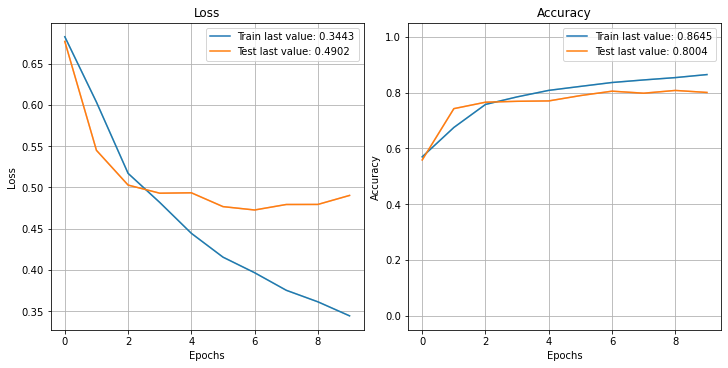

In [62]:
plot_history(history)
plt.show()

In [63]:
te = wordChanger(tr, te)

gresham changed in abbswinston
gresham changed in abbswinston
smith changed in rs
39 words changed


In [64]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr)
tr = tokenizer.texts_to_sequences(tr)
te = tokenizer.texts_to_sequences(te)

vocabulary_size = len(tokenizer.index_word)+1

In [65]:
length=max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [66]:
tr = pad_sequences(tr, padding='post', maxlen=length)
te = pad_sequences(te, padding='post', maxlen=length)

In [67]:
model = BiDirLSTM(vocabulary_size, length)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 32, 4)             55600     
                                                                 
 dropout_3 (Dropout)         (None, 32, 4)             0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 32, 32)           2688      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 17  

In [68]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [69]:
history = model.fit(x=tr, y=y, epochs=10, batch_size=96, shuffle=True, verbose=0)

In [70]:
Predictions = model.predict(x=te)

In [71]:
def comHist(base, pred, lab :str):
    plt.figure(figsize=(10,5), dpi=80)
    plt.hist(base, bins=32, alpha=1, color='g', label='baseline')
    plt.hist(pred, bins=32, alpha=0.5, color='r', label=lab, linestyle='dashed', edgecolor = 'w')
    plt.legend(loc='upper right')
    plt.title('Probabilities Distribution')
    plt.show()

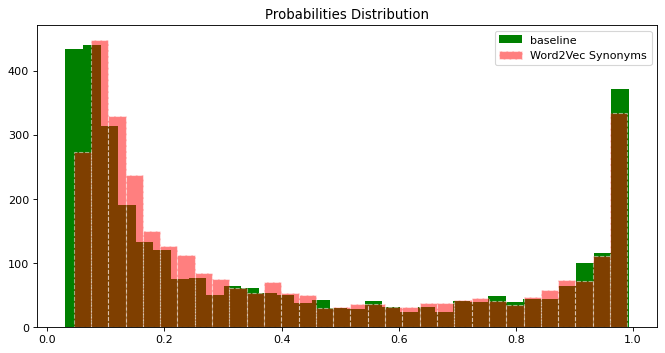

In [72]:
comHist(baseline, Predictions, "Word2Vec Synonyms")

In [73]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0


In [74]:
subm.to_csv("Submission_W2V.csv", index=False)

In [75]:
# Glove Embeddings with gensim
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, o, o = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, o, o = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, o, o = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

In [76]:
glove = api.load("glove-twitter-25")

for w in words:
    print(w + " is " + glove.most_similar(w, topn=1)[0][0])

[==================================================] 100.0% 104.8/104.8MB downloaded
fire is run
flood is closure
died is killed
accident is crash
closed is flight
help is save
twitter is facebook
air is jet
everything is something


In [77]:
vecSize = 25
w2v = gensim.models.Word2Vec(emb, vector_size = vecSize, min_count = 1, workers = 4, window = 6, sg = 1)

for w in words:
    print(w + " is " + w2v.wv.most_similar(w, topn=1)[0][0])

fire is buildings
flood is offroad
died is deaths
accident is airplane
closed is wings
help is see
twitter is dude
air is french
everything is haha


In [78]:
def gloveEmbedder(df_tr, df_te):
    etr = []
    ete = []

    for s in df_tr:
        s = [glove[f"{w}"] if w in glove.index_to_key else w2v.wv[f"{w}"] for w in s.split()]
        s = list(np.ravel(s))
        etr.append(s)

    for s in df_te:
        s = [glove[f"{w}"] if w in glove.index_to_key else w2v.wv[f"{w}"] for w in s.split()]
        s = list(np.ravel(s))
        ete.append(s)

    l=max([max([len(i) for i in etr]), max([len(i) for i in ete])])

    print("Each sentence will have a lengt of " + str(l))
    return etr, ete, l

In [79]:
emb_tr_val, emb_te_val, length_val = gloveEmbedder(tr_val, te_val)

Each sentence will have a lengt of 775


In [80]:
emb_tr_val = pad_sequences(emb_tr_val, padding='post', maxlen=length_val, dtype='float32')
emb_te_val = pad_sequences(emb_te_val, padding='post', maxlen=length_val, dtype='float32')

In [81]:
timesteps=int(length_val/vecSize)
emb_tr_val = emb_tr_val.reshape(-1, timesteps, vecSize)
emb_te_val = emb_te_val.reshape(-1, timesteps, vecSize)
shape = emb_tr_val.shape[1:]

In [82]:
def BiDirLSTM(inpShape, seeds = seed):
    np.random.seed(seeds)
    set_seed(seeds)
    
    inp = Input(shape = (inpShape), name = "input")
    drop = Dropout(0.4)(inp)
    biLstm = Bidirectional(
        LSTM(
            units =192,
            activation ='tanh',
            return_sequences = True,
            stateful = False,
            recurrent_dropout = 0.4,
            dropout = 0.4
        )
    )(drop)
    biLstm = Bidirectional(
        LSTM(
            units = 8,
            activation = 'tanh',
            return_sequences = False,
            stateful = False,
            recurrent_dropout = 0.4,
            dropout = 0.3
        )
    )(biLstm)

    out = Dense(units = 1, activation = "sigmoid")(biLstm)

    m = Model(inputs = inp, outputs = out)
    m.summary()
    return m

In [83]:
model = BiDirLSTM(inpShape = shape)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 31, 25)]          0         
                                                                 
 dropout_4 (Dropout)         (None, 31, 25)            0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 31, 384)          334848    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 16)               25152     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 360,017
Trainable params: 360,017
Non-trainab

In [85]:
optimizer = Adamax(
    learning_rate = 0.015, 
    decay = 0.0002, 
    clipvalue = 10
)

In [86]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)

In [87]:
history = model.fit(
    x = emb_tr_val, 
    y = y_tr_val,
    validation_data = (emb_te_val, y_te_val),
    epochs = 15, 
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Epoch 1/15
64/64 [==============================] - 18s 194ms/step - loss: 0.5574 - accuracy: 0.7217 - val_loss: 0.5092 - val_accuracy: 0.7681
Epoch 2/15
64/64 [==============================] - 12s 191ms/step - loss: 0.5201 - accuracy: 0.7573 - val_loss: 0.4973 - val_accuracy: 0.7773
Epoch 3/15
64/64 [==============================] - 13s 197ms/step - loss: 0.5096 - accuracy: 0.7603 - val_loss: 0.4875 - val_accuracy: 0.7839
Epoch 4/15
64/64 [==============================] - 13s 197ms/step - loss: 0.5124 - accuracy: 0.7550 - val_loss: 0.4823 - val_accuracy: 0.7655
Epoch 5/15
64/64 [==============================] - 13s 202ms/step - loss: 0.5075 - accuracy: 0.7578 - val_loss: 0.4784 - val_accuracy: 0.7813
Epoch 6/15
64/64 [==============================] - 13s 201ms/step - loss: 0.4934 - accuracy: 0.7728 - val_loss: 0.4799 - val_accuracy: 0.7866
Epoch 7/15
64/64 [==============================] - 13s 198ms/step - loss: 0.4975 - accuracy: 0.7674 - val_loss: 0.4755 - val_accuracy: 0.7951

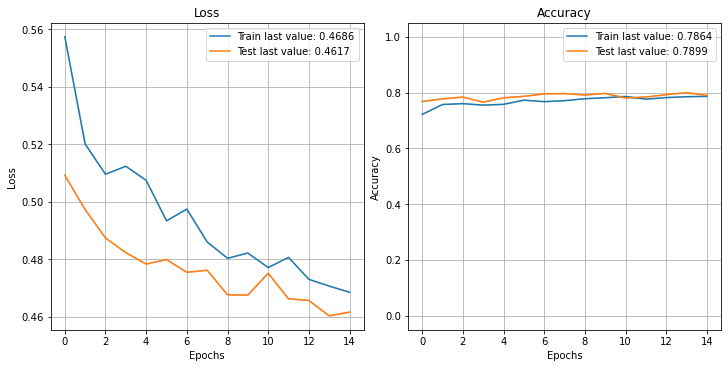

In [88]:
plot_history(history)
plt.show()

In [89]:
emb_tr, emb_te, length = gloveEmbedder(tr, te)

Each sentence will have a lengt of 825


In [90]:
emb_tr = pad_sequences(emb_tr, padding='post', maxlen=length, dtype='float32')
emb_te = pad_sequences(emb_te, padding='post', maxlen=length, dtype='float32')

In [91]:
timesteps = int(length/vecSize)
emb_tr = emb_tr.reshape(-1, timesteps, vecSize)
emb_te = emb_te.reshape(-1, timesteps, vecSize)
shape = emb_tr.shape[1:]

In [92]:
model = BiDirLSTM(inpShape=shape)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 33, 25)]          0         
                                                                 
 dropout_5 (Dropout)         (None, 33, 25)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 33, 384)          334848    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 16)               25152     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 360,017
Trainable params: 360,017
Non-trainab

In [93]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics=["accuracy"]
)

In [94]:
history = model.fit(
    x = emb_tr, 
    y = y,
    epochs = 15, 
    batch_size = 96, 
    shuffle = True,
    verbose = 0
)

In [95]:
Predictions = model.predict(
    x = emb_te
)

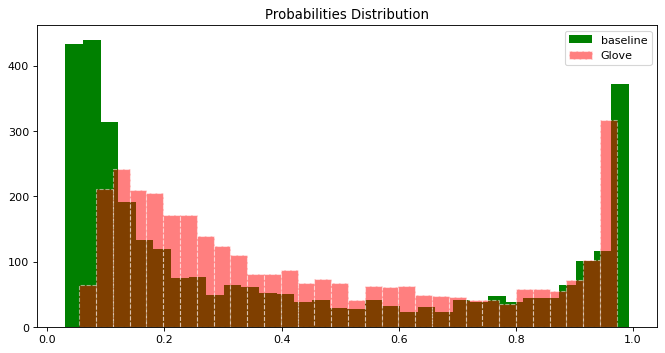

In [96]:
comHist(baseline, Predictions, "Glove")

In [97]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0


In [98]:
subm.to_csv("Submission_W2V_Embed.csv", index = False)

In [99]:
# BERT
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, _, _ = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low=0.0, high=1.0, size=train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

In [100]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [101]:
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

In [102]:
def prepareBERT(l, X, Y=None):
    inp_ids = []
    am = []

    for s in X:
        bert_inp = bert_tokenizer.encode_plus(
            s,
            add_special_tokens = True,
            max_length = l,
            padding ='max_length',
            return_attention_mask = True,
            truncation = True
        )
        inp_ids.append(bert_inp['input_ids'])
        am.append(bert_inp['attention_mask'])

    inp_ids = np.asarray(inp_ids)
    am = np.array(am)
    print(len(inp_ids));print(len(am))
    if Y is not None:
        print(len(Y))
    return inp_ids, am

In [103]:
input_ids_te_val, attention_mask_te_val = prepareBERT(length_val, te_val, y_te_val)
input_ids_tr_val, attention_mask_tr_val = prepareBERT(length_val, tr_val, y_tr_val)

1518
1518
1518
6095
6095
6095


In [104]:
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
optimizer = Adam(
    lr = 5e-5, 
    epsilon = 1e-08,
    clipvalue = 10
)

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [106]:
loss = SparseCategoricalCrossentropy(from_logits=True)

In [107]:
bert_model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = SparseCategoricalAccuracy()
)
bert_model.trainable = True
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_43 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [108]:
history = bert_model.fit(
    [input_ids_tr_val,attention_mask_tr_val],
    y_tr_val,
    batch_size = 48,
    epochs = 2,
    validation_data = ([input_ids_te_val,attention_mask_te_val],y_te_val)
)

Epoch 1/2
127/127 [==============================] - 2484s 19s/step - loss: 0.4904 - sparse_categorical_accuracy: 0.7665 - val_loss: 0.4263 - val_sparse_categorical_accuracy: 0.8195
Epoch 2/2
127/127 [==============================] - 2186s 17s/step - loss: 0.3574 - sparse_categorical_accuracy: 0.8568 - val_loss: 0.4483 - val_sparse_categorical_accuracy: 0.8235


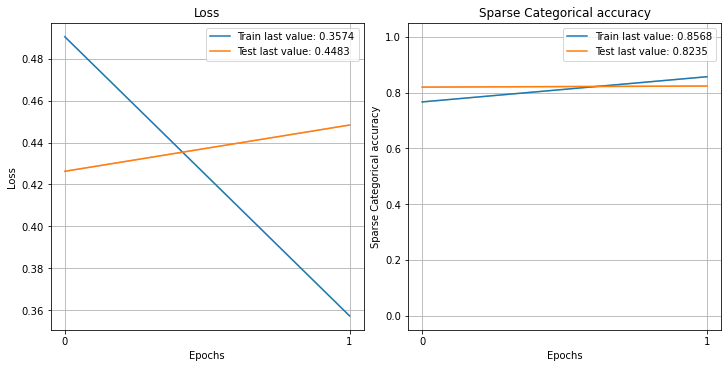

In [109]:
plot_history(history)
plt.show()

In [110]:
length = max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [111]:
input_ids_te, attention_mask_te = prepareBERT(length, te)
input_ids_tr, attention_mask_tr = prepareBERT(length, tr, y)

3263
3263
7613
7613
7613


In [112]:
bert_model.compile(
    loss = loss, 
    optimizer = optimizer, 
    metrics = SparseCategoricalAccuracy()
)
bert_model.trainable = True
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_43 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [113]:
history = bert_model.fit(
    [input_ids_tr,attention_mask_tr],
    y,
    batch_size = 48,
    epochs = 2
)

Epoch 1/2
159/159 [==============================] - 2983s 19s/step - loss: 0.3184 - sparse_categorical_accuracy: 0.8752
Epoch 2/2
159/159 [==============================] - 3189s 20s/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9045


In [114]:
Predictions = bert_model.predict(
   [input_ids_te, attention_mask_te],
    batch_size = 48
)

In [115]:
Predictions = [i[1] for i in softmax(Predictions[0]).numpy().tolist()]

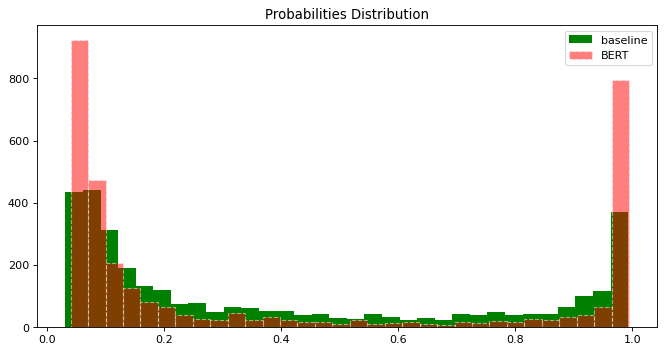

In [116]:
comHist(baseline, Predictions, "BERT")

In [117]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0


In [118]:
subm.to_csv("Submission_BERT.csv", index=False)

In [120]:
s1 = pd.read_csv("./Submission_Basic.csv")
s2 = pd.read_csv("./Submission_W2V.csv")
s3 = pd.read_csv("./Submission_W2V_Embed.csv")
s4 = pd.read_csv("./Submission_BERT.csv")

subm = pd.read_csv("input/sample_submission.csv")

Voting = np.where(s1.target + s2.target + s3.target + s4.target + s4.target >= 3, 1, 0)

subm["target"] = Voting
subm.head(7)

subm.to_csv("Submission_Voting.csv", index=False)